Deep Neural Network (DNN) - BHPD dataset
========================================
---
Introduction au Deep Learning  (IDLE) - S. Arias, E. Maldonado, JL. Parouty - CNRS/SARI/DEVLOG - 2020  

## A very simple example of **regression** (Premium edition):

Objective is to predicts **housing prices** from a set of house features. 

The **[Boston Housing Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)** consists of price of houses in various places in Boston.  
Alongside with price, the dataset also provide information such as Crime, areas of non-retail business in the town,  
age of people who own the house and many other attributes...

What we're going to do:

 - (Retrieve data)
 - (Preparing the data)
 - (Build a model)
 - Train and save the model
 - Restore saved model
 - Evaluate the model
 - Make some predictions


## 1/ Init python stuff

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from IPython.display import display, Markdown
import fidle.pwk as ooo
from importlib import reload

ooo.init()

IDLE 2020 - Practical Work Module
  Version            : 0.2
  Run time           : Monday 27 January 2020, 15:48:21
  Matplotlib style   : fidle/talk.mplstyle
  TensorFlow version : 2.0.0
  Keras version      : 2.2.4-tf


## 2/ Retrieve data

**From Keras :**
Boston housing is a famous historic dataset, so we can get it directly from [Keras datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)  

**From a csv file :**  
More fun !

In [2]:
data = pd.read_csv('./data/BostonHousing.csv', header=0)

display(data.head(5).style.format("{0:.2f}"))
print('Données manquantes : ',data.isna().sum().sum(), '  Shape is : ', data.shape)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1.00,296.00,15.30,396.90,4.98,24.00
1,0.03,0.00,7.07,0.00,0.47,6.42,78.90,4.97,2.00,242.00,17.80,396.90,9.14,21.60
2,0.03,0.00,7.07,0.00,0.47,7.18,61.10,4.97,2.00,242.00,17.80,392.83,4.03,34.70
3,0.03,0.00,2.18,0.00,0.46,7.00,45.80,6.06,3.00,222.00,18.70,394.63,2.94,33.40
4,0.07,0.00,2.18,0.00,0.46,7.15,54.20,6.06,3.00,222.00,18.70,396.90,5.33,36.20


Données manquantes :  0   Shape is :  (506, 14)


## 3/ Preparing the data
### 3.1/ Split data
We will use 80% of the data for training and 20% for validation.  
x will be input data and y the expected output

In [3]:
# ---- Split => train, test
#
data_train = data.sample(frac=0.7, axis=0)
data_test  = data.drop(data_train.index)

# ---- Split => x,y (medv is price)
#
x_train = data_train.drop('medv',  axis=1)
y_train = data_train['medv']
x_test  = data_test.drop('medv',   axis=1)
y_test  = data_test['medv']

print('Original data shape was : ',data.shape)
print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)

Original data shape was :  (506, 14)
x_train :  (354, 13) y_train :  (354,)
x_test  :  (152, 13) y_test  :  (152,)


### 3.2/ Data normalization
**Note :** 
 - All input data must be normalized, train and test.  
 - To do this we will subtract the mean and divide by the standard deviation.  
 - But test data should not be used in any way, even for normalization.  
 - The mean and the standard deviation will therefore only be calculated with the train data.

In [4]:
display(x_train.describe().style.format("{0:.2f}").set_caption("Before normalization :"))

mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

display(x_train.describe().style.format("{0:.2f}").set_caption("After normalization :"))

x_train, y_train = np.array(x_train), np.array(y_train)
x_test,  y_test  = np.array(x_test),  np.array(y_test)


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
count,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00
mean,3.50,11.26,10.98,0.05,0.55,6.30,68.18,3.83,9.29,403.31,18.54,359.90,12.38
std,8.57,23.21,6.82,0.22,0.11,0.66,28.04,2.10,8.59,167.27,2.13,88.19,6.61
min,0.01,0.00,0.74,0.00,0.39,3.86,2.90,1.13,1.00,187.00,12.60,2.52,1.92
25%,0.08,0.00,5.19,0.00,0.45,5.89,45.18,2.12,4.00,279.00,17.40,377.59,7.19
50%,0.23,0.00,8.56,0.00,0.54,6.22,76.50,3.21,5.00,329.00,19.10,391.81,11.17
75%,2.89,12.50,18.10,0.00,0.62,6.61,93.57,5.12,8.00,666.00,20.20,396.21,16.57
max,88.98,95.00,27.74,1.00,0.87,8.72,100.00,12.13,24.00,711.00,22.00,396.90,36.98


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
count,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00
mean,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.41,-0.49,-1.50,-0.23,-1.47,-3.68,-2.33,-1.29,-0.96,-1.29,-2.79,-4.05,-1.58
25%,-0.40,-0.49,-0.85,-0.23,-0.92,-0.61,-0.82,-0.81,-0.62,-0.74,-0.54,0.20,-0.78
50%,-0.38,-0.49,-0.35,-0.23,-0.11,-0.12,0.30,-0.30,-0.50,-0.44,0.26,0.36,-0.18
75%,-0.07,0.05,1.04,-0.23,0.65,0.48,0.91,0.61,-0.15,1.57,0.78,0.41,0.63
max,9.98,3.61,2.46,4.31,2.93,3.67,1.13,3.95,1.71,1.84,1.62,0.42,3.72


## 4/ Build a model
More informations about : 
 - [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
 - [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
 - [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
 - [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [5]:
  def get_model_v1(shape):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(64, activation='relu', input_shape=shape))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(1))
    
    model.compile(optimizer = 'rmsprop',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

## 5/ Train the model
### 5.1/ Get it

In [6]:
model=get_model_v1( (13,) )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


### 5.2/ Add callback

In [7]:
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_model.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 5.3/ Train it

In [8]:
history = model.fit(x_train,
                    y_train,
                    epochs          = 100,
                    batch_size      = 10,
                    verbose         = 0,
                    validation_data = (x_test, y_test),
                    callbacks       = [savemodel_callback])

## 6/ Evaluate
### 6.1/ Model evaluation
MAE =  Mean Absolute Error (between the labels and predictions)  
A mae equal to 3 represents an average error in prediction of $3k.

In [9]:
score = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 14.2504
x_test / mae       : 2.4316
x_test / mse       : 14.2504


### 6.2/ Training history
What was the best result during our training ?

In [10]:
print("min( val_mae ) : {:.4f}".format( min(history.history["val_mae"]) ) )

min( val_mae ) : 2.2208


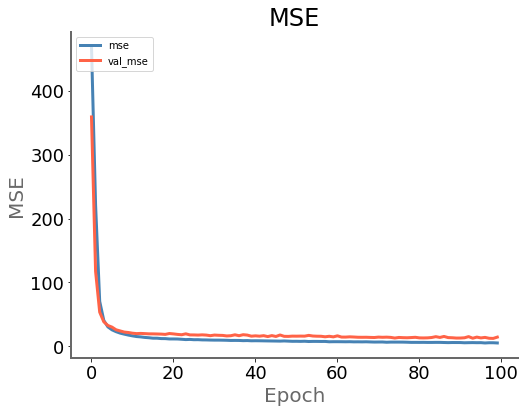

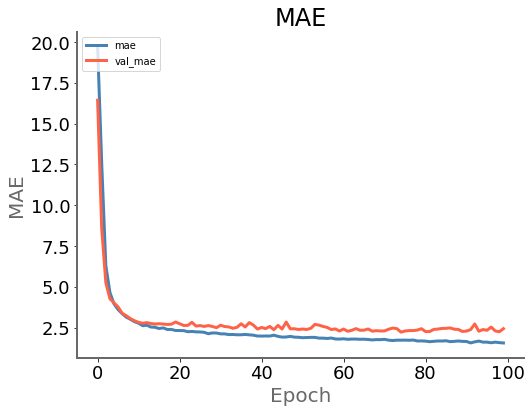

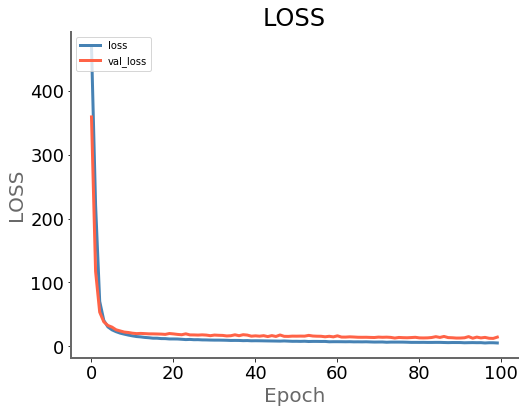

In [11]:
reload(ooo)
ooo.plot_history(history, plot={'MSE' :['mse', 'val_mse'],
                                'MAE' :['mae', 'val_mae'],
                                'LOSS':['loss','val_loss']})

## 7/ Restore a model :

### 7.1/ Reload model

In [12]:
loaded_model = tf.keras.models.load_model('./run/models/best_model.h5')
loaded_model.summary()
print("Loaded.")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________
Loaded.


### 7.2/ Evaluate it :

In [13]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 12.2278
x_test / mae       : 2.2441
x_test / mse       : 12.2278


### 7.3/ Make a prediction

In [23]:
mon_test=[ 1.26425925, -0.48522739,  1.0436489 , -0.23112788,  1.37120745,
       -2.14308942,  1.13489104, -1.06802005,  1.71189006,  1.57042287,
        0.77859951,  0.14769795,  2.7585581 ]

mon_test=np.array(mon_test).reshape(1,13)

In [24]:

predictions = loaded_model.predict( mon_test )
print("Prédiction : {:.2f} K$   Reality : {:.2f} K$".format(predictions[0][0], y_train[13]))

Prédiction : 8.66 K$   Reality : 10.20 K$


-----
That's all folks !